https://github.com/Kabanosk/whisper-website
https://github.com/openai/whisper/discussions/264

In [ ]:
# %%capture
# %pip install python-dotenv

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import yt_dlp
import unzip
from typing import List, Callable, Optional, Dict

# increase column width
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', None)

# Download Audio and Transcribe

In [2]:
VIDEO_URL = "https://youtu.be/DgTjSrrf6GQ"
AUDIO_FILE_NAME = "./data/audio/Lex_Podcast.mp3"
AUDIO_QUALITY = 5 # 0 best - 10 worst (default 5)
AUDIO_FORMAT = "mp3"
FFMPEG_LOCATION = "ffmpeg-master-latest-win64-gpl/bin"
SUBTITLE_LANGUAGE = "en.*"
TRANSCRIPT_FILE_NAME = "./data/transcript.txt"
SUBTITLE_FORMAT = "srt"

In [ ]:
import wget
import os
import zipfile

FFMPEG_URL = 'https://github.com/yt-dlp/FFmpeg-Builds/releases/download/latest/ffmpeg-master-latest-win64-gpl.zip'
ZIP_PATH = './ffmpeg.zip'
EXTRACT_DIR = './'

if not os.path.exists(ZIP_PATH):
    print('Downloading ffmpeg...')
    wget.download(FFMPEG_URL, ZIP_PATH)

    print('Unzipping...') 
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    
    print('Removing zip file...')
    os.remove(ZIP_PATH)

else:
    print('Already downloaded.')

In [ ]:
!yt-dlp -xv --ffmpeg-location ffmpeg-master-latest-win64-gpl/bin --audio-format mp3  -o data/audio/Lex_Podcast -- {"https://youtu.be/DEu24V8vfb8"}
#!yt-dlp -xv --ffmpeg-location {FFMPEG_LOCATION} --audio-format {AUDIO_FORMAT}  -o {AUDIO_FILE_NAME} -- {"https://youtu.be/DEu24V8vfb8"}

In [ ]:
import openai
from dotenv import load_dotenv, find_dotenv
import os

_ = load_dotenv(find_dotenv())  # add .env to .gitignore
openai.api_key = os.getenv("OPENAI_API_KEY")


In [ ]:
audio_file = open("data/audio/Lexicap.mp3", "rb")
transcript = openai.Audio.transcribe("whisper-1", audio_file, response_format=SUBTITLE_FORMAT)

In [ ]:
# with open("langchain.srt", "w") as f:
#     f.write(transcript)

## Longer Inputs
By default, the Whisper API only supports files that are less than 25 MB. If you have an audio file that is longer than that, you will need to break it up into chunks of 25 MB's or less or used a compressed audio format. To get the best performance, we suggest that you avoid breaking the audio up mid-sentence as this may cause some context to be lost.

One way to handle this is to use the [PyDub open source Python package](https://github.com/jiaaro/pydub) to split the audio:

In [ ]:
from pydub import AudioSegment

song = AudioSegment.from_mp3("good_morning.mp3")

# PyDub handles time in milliseconds
ten_minutes = 10 * 60 * 1000

first_10_minutes = song[:ten_minutes]

first_10_minutes.export("good_morning_10.mp3", format="mp3")

### Prompting
* Check out [OpenAI](https://platform.openai.com/docs/guides/speech-to-text/prompting)

# Download Transcript

In [ ]:
# Download the transcript with yt-dlp
!yt-dlp --write-auto-sub --skip-download --sub-format {SUBTITLE_FORMAT} --sub-lang {SUBTITLE_LANGUAGE} --output {TRANSCRIPT_FILE_NAME} -- {VIDEO_URL}

## Data Preparation
Let's change the name of the raw caption files:

In [ ]:
# Get a clean list of podcast titles
import re 

def clean_titles(title):
    title = re.sub(r'\[(.*?)\]\((.*?)\)', r'\1', title)
    title = re.sub(r'\|.*?\d+', '', title)
    title = title.rstrip().replace(' ', '_').replace(':', '_').replace('&','and').lower()
    title = re.sub(r'[^a-zA-Z0-9_]', '', title)
    return title

with open('./data/Lexicap.md', 'r') as f:
    text = f.read()

titles = text.split('\n')
titles = [clean_titles(title) for title in titles if title != '']

In [ ]:
# Rename the transcript files
import os

TRANSCRIPT_PATH = "./data/transcripts/"
FILE_EXTENSION = '.vtt'

for org_filename, line_idx in zip(os.listdir(path=TRANSCRIPT_PATH), titles):
    if org_filename.endswith(FILE_EXTENSION):
        print(org_filename)
        # rename file 
        new_filename = f"{line_idx}{FILE_EXTENSION}"
        os.rename(f"{TRANSCRIPT_PATH}{org_filename}", f"{TRANSCRIPT_PATH}{new_filename}")

# Start
### Data Cleaning

In [3]:
TRANSCRIPT_PATH = "./data/transcripts/"
FILE_EXTENSION = '.vtt'

In [4]:
# Create new transcript file with timestamp and text
TRANSCRIPT_FILE_NAME = "45_michio_kaku__future_of_humans_aliens_space_travel_and_physics.vtt"
NEW_TRANSCRIPT_FILE_NAME = "45_michio_kaku__future_of_humans_aliens_space_travel_and_physics.csv"


with open(f"{TRANSCRIPT_PATH}{TRANSCRIPT_FILE_NAME}") as oldfile, open(f"{NEW_TRANSCRIPT_FILE_NAME}", 'w') as newfile:
    old_lines = oldfile.read().split('\n')
    clean_lines = [line for line in old_lines if line not in ['', 'WEBVTT']]

    for line_idx in range(0, len(clean_lines)-1, 2):
         timestamp = clean_lines[line_idx].split('-->')[0].strip()
         # Standardize timestamp format
         timestamp = "00:" + timestamp if len(timestamp.split(':')) < 3 else timestamp
         timestamp = "0" + timestamp if len(timestamp.split(':')[0]) < 2 else timestamp
         text = clean_lines[line_idx+1].rstrip()
         new_line = f"{timestamp};{text}\n"
         newfile.write(new_line)


In [5]:
df = pd.read_csv(f"{NEW_TRANSCRIPT_FILE_NAME}"
                            ,sep=';', 
                            header=None, names=['timestamp', 'text'],)
df.head(25)

,timestamp,text
0,00:00:00.000,The following is a conversation with Michio Kaku.
1,00:00:02.800,"He's a theoretical physicist, futurist,"
2,00:00:05.120,and professor at the City College of New York.
3,00:00:08.360,He's the author of many fascinating books
4,00:00:10.760,that explore the nature of our reality
5,00:00:12.840,and the future of our civilization.
6,00:00:15.520,"They include Einstein's Cosmos, Physics of the Impossible,"
7,00:00:19.200,"Future of the Mind, Parallel Worlds,"
8,00:00:21.600,"and his latest, The Future of Humanity,"
9,00:00:24.240,"Terraforming Mars Interstellar Travel,"


* Since Whisper has not skipped the punctuations in the transcript, we can reconstruct full sentences, ensuring that each sentence is ended with a period `.`

In [7]:
# Recreate the dataframe with full sentences
transcript_df = pd.DataFrame(columns=df.columns)

for idx, timestamp, text in df.itertuples():
    while text[-1] != '.':
        idx += 1
        text += df.loc[idx]['text']
    transcript_df = pd.concat([transcript_df, pd.DataFrame({'timestamp': timestamp, 'text': text}, index=[0])], ignore_index=True)

# Remove any piece of text if it is included in previous text
not_part_of_previous = [True]
for i in range(1, len(transcript_df)):
    not_part_of_previous.append(transcript_df['text'][i] not in transcript_df['text'][i-1])
transcript_df = transcript_df[not_part_of_previous] 


# 1. NER
* Add column for persons, orginazations, books, companies, countries, places.

## Mentioned Books

In [8]:
#%%capture
# %pip install -U spaCy
# %pip install 'spacy[transformers]'
#!python -m spacy download en_core_web_trf # download best-matching version of specific model

In [9]:
import spacy
# load a pipeline package by name and return nlp object
nlp = spacy.load("en_core_web_trf", disable=["tok2vec","parser"]) #disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner"]

# check processing pipeline components of nlp object
nlp.pipeline


[('transformer',
  <spacy_transformers.pipeline_component.Transformer at 0x20aea9dfa00>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x20aea9df9a0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x20aea993ac0>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x20aeab31380>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x20aea9d5620>)]

In [10]:
# create a Doc by processing a string of text with the nlp object
doc = nlp("So I'm with Jared Diamond, you know, in the book Collapse, \
          where he points out studying the collapse of major civilizations, \
          that it often happens right after things appear to never have been better. Hmm.")


# iterate over tokens in a Doc
print("Entities: ", [e.text for e in doc.ents if e.label_ == 'WORK_OF_ART'])


Entities:  ['Collapse']


In [11]:
# Find book related sentences in the transcript
book_related_phrases = [
    "book", "books", "i read", 
    "everyone should read", "you should read", "he wrote a novel",
    "i recommend", "highly recommend", "you must read", 
    "shouldn't miss", "top books", "best books", 
    "favorite book", "my favorite books", "book you need to read",
    "books to read before", "essential books", "great book for",
    "worthy read", "book of the year", "award winning book"
]




def contains_book_phrase(text: str, search_list: List[str]) -> bool:
    """
    Check if a text contains any of a list of book-related phrases.

    :param text: The text to search within.
    :param search_list: A list of phrases to search for.
    :return: True if any phrase is found in the text, False otherwise.
    """
    return any(phrase in text.lower() for phrase in search_list)


transcript_df["is_book_related"] = transcript_df["text"].apply(contains_book_phrase, search_list=book_related_phrases)

In [12]:
def get_book_titles_candidates(text: str, pipeline: Callable[[str], 'Doc']) -> List[str]:
    """
    Extract potential book titles from a text using a given NLP model.

    :param text: The text to extract titles from.
    :param pipeline: The NLP model to use for text processing.
    :return: A list of potential book titles.
    """
    doc = nlp(text)
    book_titles_candidates = [entity.text for entity in doc.ents if entity.label_ == 'WORK_OF_ART']
    return book_titles_candidates


In [13]:
transcript_df.query("is_book_related == True")["text"].apply(get_book_titles_candidates,
                                                                  pipeline=nlp)

3                               []
182                             []
341                             []
478       [The Future of the Mind]
638                             []
859                             []
940                             []
954     [The Theory of Everything]
957                             []
1149          [Future of Humanity]
Name: text, dtype: object

In [14]:
# Add book candidates to the dataframe
transcript_df["book_candidates"] = transcript_df.apply(lambda x: get_book_titles_candidates(x["text"], pipeline=nlp) \
                                                                 if x["is_book_related"] else [], axis=1)

In [15]:
transcript_df.query("is_book_related == True")

,timestamp,text,is_book_related,book_candidates
3,00:00:08.360,He's the author of many fascinating books that explore the nature of our reality and the future of our civilization.,True,[]
182,00:08:30.920,"And Stephen Hawking, for example, even in his last book, even said that this is an argument against the existence of God.",True,[]
341,00:16:04.760,"If you read the book, the aliens did not have evil intentions toward homo sapiens.",True,[]
478,00:22:38.600,"I have a book, The Future of the Mind, where I detail some of these breakthroughs.",True,[The Future of the Mind]
638,00:29:54.080,"Our ancestors were lucky if they had one line, just one line in a church book, saying the date they were baptized and the date they died.",True,[]
859,00:40:07.240,"For Isidor Rabi, it was a book about the planets.",True,[]
940,00:44:06.200,"That desk had a book on it, which was opened.",True,[]
954,00:44:43.160,"And then over the years, I found out the guy had a name, Albert Einstein, and that book was The Theory of Everything.",True,[The Theory of Everything]
957,00:44:53.080,"Well, today I can read that book.",True,[]
1149,00:53:36.600,"And in my book, Future of Humanity, I even speculate beyond that, that by the end of this century, we'll probably have the first starships.",True,[Future of Humanity]


In [16]:
import requests
from typing import Optional, Dict

def get_book_info(title: str) -> Optional[Dict]:
    """
    Fetch book information from Google Books API.

    :param title: The title of the book to search for.
    :return: A dictionary containing book information if found, None otherwise.
    """
    try:
        response = requests.get(f"https://www.googleapis.com/books/v1/volumes?q={title}")

        # Raise an exception if the request was unsuccessful
        response.raise_for_status()

    except requests.HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
        return None
    except Exception as err:
        print(f'Other error occurred: {err}')
        return None

    else:
        data = response.json()
        most_rated_book = None
        # Find popular book (highest ratings count)
        max_ratings_count = -1
        for book in data["items"]:
            ratings_count = book["volumeInfo"].get("ratingsCount", 0)
            if ratings_count > max_ratings_count:
                max_ratings_count = ratings_count
                most_rated_book = book

        if most_rated_book is None:
            return None

    return most_rated_book["volumeInfo"]
# ["Einstein's Cosmos",
#  'Physics of the Impossible',
#  'Future of the Mind',
#  'Parallel Worlds',
#  'Future of Humanity',
#  'Terraforming Mars Interstellar Travel']
get_book_info('Parallel Worlds')


{'title': 'Parallel Worlds',
 'subtitle': 'A Journey Through Creation, Higher Dimensions, and the Future of the Cosmos',
 'authors': ['Michio Kaku'],
 'publisher': 'Anchor',
 'publishedDate': '2006-02-14',
 'description': 'Sheds new light on discoveries that have revolutionized the field of cosmology and transformed understanding of the universe, offering an explanation of the multiverse M-theory and its implications in terms of the fate of our own universe.',
 'industryIdentifiers': [{'type': 'OTHER', 'identifier': 'UVA:X004898840'}],
 'readingModes': {'text': False, 'image': False},
 'pageCount': 452,
 'printType': 'BOOK',
 'categories': ['Science'],
 'averageRating': 3.5,
 'ratingsCount': 11,
 'maturityRating': 'NOT_MATURE',
 'allowAnonLogging': False,
 'contentVersion': '0.2.1.0.preview.0',
 'panelizationSummary': {'containsEpubBubbles': False,
  'containsImageBubbles': False},
 'imageLinks': {'smallThumbnail': 'http://books.google.com/books/content?id=21NGAAAAYAAJ&printsec=frontco

## Identify Other Entities

In [17]:
# %%capture
# %pip install textacy

In [18]:
import textacy

entity_types = ['PERSON', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'NORP', 'WORK_OF_ART', 'LAW']

from typing import List, Optional, Union
from spacy.tokens import Doc

def extract_entities(doc: Doc, 
                     include_types: Optional[Union[str, List[str]]] = None, 
                     sep: str = ' ') -> List[str]:
    """
    Extract named entities from a document and return them as strings.

    :param doc: The document to extract entities from.
    :param include_types: The types of entities to include. If None, include all types.
    :param sep: The separator to use when joining lemmas of multi-token entities.
    :return: A list of named entities in the form 'lemma/label'.
    """
    ents = textacy.extract.entities(doc, 
                                    include_types=include_types, 
                                    exclude_types=None, 
                                    drop_determiners=True, 
                                    min_freq=1)
    
    return [sep.join([token.text for token in entity])+'/'+entity.label_ for entity in ents]

* When processing large volumes of text, it is recommended to use spaCys batch processing for a significant performance gain. The function `nlp.pipeline` takes an iterable of texts, processes them internally as batch, and yields a list fo processed Doc objects in the same order as the input data.
* To use `nlp.pipeline`, we first have to define a batch size. Then we can loop over the batches and call `nlp.pipe`. In the inner loop we extract the features from the processed doc and write the values back into the a list:

In [19]:
# Extract entities from the transcript
import numpy as np
from tqdm import tqdm

batch_size = 50
batches = np.ceil(len(transcript_df) / batch_size).astype(int)

named_entities = []

# loop over batches, step size is equal to batch size
for i in tqdm(range(0, len(transcript_df), batch_size), total=batches):
    docs = nlp.pipe(transcript_df['text'][i:i+batch_size])
    
    for doc in docs:
        named_entities.append(extract_entities(doc, include_types=entity_types)) 

transcript_df['named_entities'] = named_entities 

100%|██████████| 13/13 [00:53<00:00,  4.12s/it]


In [20]:
# Add columns for each entity type
for ent_type in entity_types:
    transcript_df[ent_type.lower()] = transcript_df["named_entities"].apply(lambda x: \
                                                                            [entity.split('/')[0] for entity in x if entity.split('/')[1] == ent_type])

In [21]:
transcript_df.head(2)

,timestamp,text,is_book_related,book_candidates,named_entities,person,org,gpe,loc,product,event,norp,work_of_art,law
0,00:00:00.000,The following is a conversation with Michio Kaku.,False,[],[Michio Kaku/PERSON],[Michio Kaku],[],[],[],[],[],[],[],[]
1,00:00:02.800,"He's a theoretical physicist, futurist, and professor at the City College of New York.",False,[],[City College of New York/ORG],[],[City College of New York],[],[],[],[],[],[],[]


In [22]:
def contains_empty_list(df: pd.DataFrame, col_name: str) -> bool:
    """
    Check if a column in a DataFrame contains any empty lists.

    :param df: The DataFrame to check.
    :param col_name: The name of the column to check.
    :return: True if any empty list is found, False otherwise.
    """
    return df[col_name].apply(lambda x: x == []).any()


# Find columns with empty lists
cols_to_clean = [col for col in transcript_df.columns if contains_empty_list(transcript_df, col)]

# Remove empty lists 
for ent_type in cols_to_clean:
    transcript_df[ent_type] = transcript_df[ent_type].apply(lambda x: x if len(x) > 0 else None)

In [23]:
from collections import Counter 
import pandas as pd
from typing import Optional, Callable

def count_words(dataframe: pd.DataFrame, 
                column: str, 
                preprocess: Optional[Callable[[str], str]] = None, 
                min_frequency: int = 1) -> pd.DataFrame:
    """
    Count words in a specific column of a DataFrame.

    :param dataframe: The DataFrame to count words from.
    :param column: The column to count words in. Should be tokenized.
    :param preprocess: An optional function to preprocess the words before counting.
    :param min_frequency: The minimum frequency for a word to be included in the output.
    :return: A DataFrame sorted by word frequency, containing words and their frequencies.
    """
    word_counter = Counter()

    # If a preprocessing function is provided, apply it before counting words
    if preprocess:
        dataframe[column].map(lambda doc: word_counter.update(preprocess(doc)))
    else:
        dataframe[column].map(word_counter.update)

    # Convert Counter to DataFrame
    word_freq_df = pd.DataFrame.from_dict(word_counter, orient='index', columns=['freq'])
    
    # Filter words by minimum frequency
    word_freq_df = word_freq_df.query('freq >= @min_frequency')
    
    # Set index name for the dataframe
    word_freq_df.index.name = column

    # Sort DataFrame by frequency
    return word_freq_df.sort_values('freq', ascending=False)


In [24]:
# %%capture
# %pip install WordCloud

In [25]:
from wordcloud import WordCloud 
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

def generate_word_cloud(data: pd.DataFrame,
                        col_name: str, 
                        max_words: int = 200) -> None:
    """
    Generate a word cloud from word frequencies.

    :param data: A pandas DataFrame containing text data.
    :param col_name: The column name to count words from.
    :param max_words: The maximum number of words in the word cloud.
    """
    word_frequencies = count_words(data, col_name).freq

    # Convert pandas Series to Counter object
    word_frequencies = Counter(word_frequencies.fillna(0).to_dict())

    # Create wordcloud object
    word_cloud = WordCloud(width=800, height=400, 
                           background_color= "black", colormap="Paired", 
                           max_font_size=150, max_words=max_words)

    # Generate word cloud image from frequencies
    word_cloud.generate_from_frequencies(word_frequencies)

    # Display the cloud using matplotlib 
    plt.title(col_name.capitalize()) 
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")


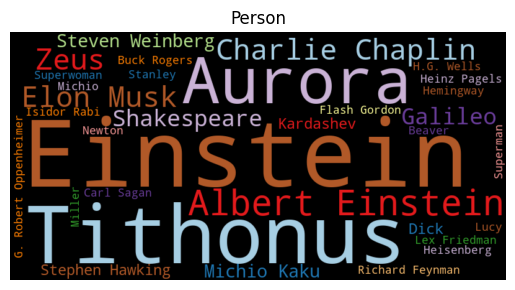

In [26]:
generate_word_cloud(transcript_df, 'person')

In [25]:
transcript_df.head(2)

,timestamp,text,is_book_related,book_candidates,named_entities,person,org,gpe,loc,product,event,norp,work_of_art,law
0,00:00:00.000,The following is a conversation with Michio Kaku.,False,None,[Michio Kaku/PERSON],[Michio Kaku],None,None,None,None,None,None,None,None
1,00:00:02.800,"He's a theoretical physicist, futurist, and professor at the City College of New York.",False,None,[City College of New York/ORG],None,[City College of New York],None,None,None,None,None,None,None


# Q&A
## Prepare the data:

For further use in text summariztion and topic modelling:

In [27]:
TRANSCRIPT_CSV_FILE = "data\michio_kaku_transcript_topic.csv"
transcript_df['group'] = transcript_df.index // 8
transcript_df_topic = transcript_df.groupby('group').agg({
    'timestamp': 'first',
    'text': ' '.join
})
transcript_df_topic.to_csv(TRANSCRIPT_CSV_FILE, index=False)

For question answering and book identification:

In [28]:
transcript_df['group'] = transcript_df.index // 20
grouped_transcript_df = transcript_df.groupby('group').agg({
    'timestamp': 'first',
    'text': ' '.join,
    'is_book_related': 'any',
    'book_candidates': 'sum',
    'named_entities': 'sum',
    
})

I will add a new column with that contains identified named-entities in plain text. First, let's create a column with entity dict:

In [29]:
def entities_to_dict(entities):
    """
    This function takes a list of entities in the format "entity/ENTITY_TYPE" and returns a dictionary
    where the keys are entity types and the values are lists of entities of that type.

    Parameters:
    entities (list): The input list of entity strings to be processed. Each entity string should be in the format
                     "entity/ENTITY_TYPE". 

    Returns:
    dict: A dictionary where the keys are descriptions of entity types (as strings), and the values are lists of 
          entities (as strings) of the corresponding type. If the input is not a list, returns an empty dictionary.
    """

    # Define a mapping from entity types to their descriptions
    # entity_type_mapping = {
    #     'PERSON': 'People, including fictional',
    #     'NORP': 'Nationalities or religious or political groups',
    #     'ORG': 'Companies, agencies, and institutions',
    #     'GPE': 'Countries, cities, and states',
    #     'LOC': 'Non-GPE locations, mountain ranges, bodies of water',
    #     'PRODUCT': 'Objects, vehicles, foods, etc. (Not services)',
    #     'EVENT': 'Named hurricanes, battles, wars, sports events, etc',
    #     'WORK_OF_ART': 'Titles of books, songs, etc',
    #     'LAW': 'Named documents made into laws',
    # }


    if not isinstance(entities, list):
        return {}

    entities_by_type = {}
    for entity in entities:
        name, entity_type = entity.split('/')
        #Use the mapping to change the keys
        # entity_type = entity_type_mapping.get(entity_type, entity_type)
        if entity_type not in entities_by_type:
            entities_by_type[entity_type] = []
        entities_by_type[entity_type].append(name)
    return entities_by_type


In [30]:
# Apply the helper function
grouped_transcript_df['named_entities_dict'] = grouped_transcript_df['named_entities'].apply(entities_to_dict)

In [31]:
grouped_transcript_df.head(2)

,timestamp,text,is_book_related,book_candidates,named_entities,named_entities_dict
group,,,,,,
0,00:00:00.000,"The following is a conversation with Michio Kaku. He's a theoretical physicist, futurist, and professor at the City College of New York. He's the author of many fascinating books that explore the nature of our reality and the future of our civilization. They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth. I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding. That, to me, is where artificial intelligence is today, just outside of our understanding, a place we have to reach for if we're to uncover the mysteries of the human mind and build human level and superhuman level AI systems that transform our world for the better.",True,0,"[Michio Kaku/PERSON, City College of New York/ORG, Einstein/PERSON, Cosmos/WORK_OF_ART, Physics of the Impossible/WORK_OF_ART, Future of the Mind/WORK_OF_ART, Parallel Worlds/WORK_OF_ART, Future of Humanity/WORK_OF_ART, Terraforming Mars Interstellar Travel/WORK_OF_ART]","{'PERSON': ['Michio Kaku', 'Einstein'], 'ORG': ['City College of New York'], 'WORK_OF_ART': ['Cosmos', 'Physics of the Impossible', 'Future of the Mind', 'Parallel Worlds', 'Future of Humanity', 'Terraforming Mars Interstellar Travel']}"
1,00:00:56.640,"This is the Artificial Intelligence Podcast. If you enjoy it, subscribe on YouTube, give it five stars on iTunes, support it on Patreon, or simply connect with me on Twitter at Lex Friedman, spelled F R I D M A N. And now, here's my conversation with Michio Kaku. You've mentioned that we just might make contact with aliens or at least hear from them within this century. Can you elaborate on your intuition behind that optimism? Well, this is pure speculation, of course. Of course. Given the fact that we've already identified 4,000 exoplanets orbiting other stars, and we have a census of the Milky Way galaxy for the first time, we know that on average, every single star, on average, has a planet going around it, and about one fifth or so of them have Earth sized planets going around them.",False,0,"[Artificial Intelligence Podcast/ORG, YouTube/ORG, iTunes/ORG, Lex Friedman/PERSON, Michio Kaku/PERSON, Milky Way/LOC, Earth/LOC]","{'ORG': ['Artificial Intelligence Podcast', 'YouTube', 'iTunes'], 'PERSON': ['Lex Friedman', 'Michio Kaku'], 'LOC': ['Milky Way', 'Earth']}"


In [32]:
# Convert list to string separated by commas
def list_to_str(lst):
    """
    This function takes a list of strings and converts it into a single string, with elements separated by commas.

    Parameters:
    lst (list or str): The input list or string to be formatted.

    Returns:
    str: The formatted string if the input is a list of strings, otherwise the input itself.
    """
    if isinstance(lst, list):
        if len(lst) > 1:
            return ', '.join(lst[:-1]) + ', and ' + lst[-1]
        elif lst:
            return lst[0]
    return lst

# Then generate the new 'named_entities' column
def entities_plain_txt(row):
    """
    Converts a dictionary of entity types and entities into a plain text.

    Parameters:
    row (dict): Dictionary where keys are entity types and values are lists of entities.

    Returns:
    str: A formatted string that lists each entity type and its entities.
    """
    output = ""
    for entity_type, entities in row.items():
        entities_str = list_to_str(entities)
        output += f'{entity_type.title()}: {entities_str}\n'
    return output

In [33]:
grouped_transcript_df['named_entities'] = grouped_transcript_df['named_entities_dict'].apply(entities_plain_txt)

In [34]:
grouped_transcript_df.head(2)

,timestamp,text,is_book_related,book_candidates,named_entities,named_entities_dict
group,,,,,,
0,00:00:00.000,"The following is a conversation with Michio Kaku. He's a theoretical physicist, futurist, and professor at the City College of New York. He's the author of many fascinating books that explore the nature of our reality and the future of our civilization. They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth. I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding. That, to me, is where artificial intelligence is today, just outside of our understanding, a place we have to reach for if we're to uncover the mysteries of the human mind and build human level and superhuman level AI systems that transform our world for the better.",True,0,"Person: Michio Kaku, and Einstein\nOrg: City College of New York\nWork_Of_Art: Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, Future of Humanity, and Terraforming Mars Interstellar Travel\n","{'PERSON': ['Michio Kaku', 'Einstein'], 'ORG': ['City College of New York'], 'WORK_OF_ART': ['Cosmos', 'Physics of the Impossible', 'Future of the Mind', 'Parallel Worlds', 'Future of Humanity', 'Terraforming Mars Interstellar Travel']}"
1,00:00:56.640,"This is the Artificial Intelligence Podcast. If you enjoy it, subscribe on YouTube, give it five stars on iTunes, support it on Patreon, or simply connect with me on Twitter at Lex Friedman, spelled F R I D M A N. And now, here's my conversation with Michio Kaku. You've mentioned that we just might make contact with aliens or at least hear from them within this century. Can you elaborate on your intuition behind that optimism? Well, this is pure speculation, of course. Of course. Given the fact that we've already identified 4,000 exoplanets orbiting other stars, and we have a census of the Milky Way galaxy for the first time, we know that on average, every single star, on average, has a planet going around it, and about one fifth or so of them have Earth sized planets going around them.",False,0,"Org: Artificial Intelligence Podcast, YouTube, and iTunes\nPerson: Lex Friedman, and Michio Kaku\nLoc: Milky Way, and Earth\n","{'ORG': ['Artificial Intelligence Podcast', 'YouTube', 'iTunes'], 'PERSON': ['Lex Friedman', 'Michio Kaku'], 'LOC': ['Milky Way', 'Earth']}"


In [35]:
# Concatenate text, named entities, and book candidates into a single column
final_text = grouped_transcript_df.apply(lambda row: f"{row['text']}\n\n" \
                                            f"Named Entities:\n{row['named_entities']}\n\n", axis=1)


# creating the new DataFrame
df_final = pd.DataFrame({
    'timestamp': grouped_transcript_df['timestamp'],
    'text': final_text
})

#df_final = grouped_transcript_df[['timestamp', 'text', 'named_entities']].copy()

In [36]:
df_final.head(2)

,timestamp,text
group,,
0,00:00:00.000,"The following is a conversation with Michio Kaku. He's a theoretical physicist, futurist, and professor at the City College of New York. He's the author of many fascinating books that explore the nature of our reality and the future of our civilization. They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth. I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding. That, to me, is where artificial intelligence is today, just outside of our understanding, a place we have to reach for if we're to uncover the mysteries of the human mind and build human level and superhuman level AI systems that transform our world for the better.\n\nNamed Entities:\nPerson: Michio Kaku, and Einstein\nOrg: City College of New York\nWork_Of_Art: Cosm..."
1,00:00:56.640,"This is the Artificial Intelligence Podcast. If you enjoy it, subscribe on YouTube, give it five stars on iTunes, support it on Patreon, or simply connect with me on Twitter at Lex Friedman, spelled F R I D M A N. And now, here's my conversation with Michio Kaku. You've mentioned that we just might make contact with aliens or at least hear from them within this century. Can you elaborate on your intuition behind that optimism? Well, this is pure speculation, of course. Of course. Given the fact that we've already identified 4,000 exoplanets orbiting other stars, and we have a census of the Milky Way galaxy for the first time, we know that on average, every single star, on average, has a planet going around it, and about one fifth or so of them have Earth sized planets going around them.\n\nNamed Entities:\nOrg: Artificial Intelligence Podcast, YouTube, and iTunes\nPerson: Lex Friedman, and Michio Kaku\nLoc: Milky Way, and Earth\n\n\n"


In [37]:
df_final.to_csv('data\michio_kaku_transcript.csv', index=False)

## Quesion answering with LangChain 
Question answering over documents consists of four steps:

1. Create an index : There are three main steps going on after the documents are loaded:
    * Splitting documents into chunks 
    * Creating embeddings for each document
    * Storing documents and embeddings in a vectorstore



2. Create a Retriever from that index
3. Create a question answering chain

4. Ask questions!
---
* See also: 
    * [LangChain Documentation](https://python.langchain.com/en/latest/modules/indexes/getting_started.html)
    * [Medium](https://towardsdatascience.com/4-ways-of-question-answering-in-langchain-188c6707cc5a) 
    * [LangChain Documentaion](https://python.langchain.com/docs/modules/chains/popular/chat_vector_db)

In [38]:
import openai
from dotenv import load_dotenv, find_dotenv
import os

_ = load_dotenv(find_dotenv())  # add .env to .gitignore
openai.api_key = os.getenv("OPENAI_API_KEY")

In [39]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader 
from langchain.vectorstores import DocArrayInMemorySearch
from IPython.display import display, Markdown

In [40]:
# Load csv data with a single row per document.
file = 'data\michio_kaku_transcript.csv'

loader = CSVLoader(file_path=file,  encoding='utf-8')

docs = loader.load()

In [41]:
# # Access data from a specific column
# column_data = [doc.page_content['text'] for doc in docs]

Each document represents one row of the CSV file. Every row is converted into a key/value pair and outputted to a new line in the document’s ``page_content``.

In [42]:
docs[0]

Document(page_content="timestamp: 00:00:00.000\ntext: The following is a conversation with Michio Kaku.  He's a theoretical physicist, futurist, and professor at the City College of New York.  He's the author of many fascinating books that explore the nature of our reality and the future of our civilization.  They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth.  I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding.  That, to me, is where artificial intelligence is today, just outside of our understanding, a place we have to reach for if we're to uncover the mysteries of the human mind and build human level and superhuman level AI systems that transform our world for the better.\n\nNamed Entities:\nPerson: Michio Kaku, and Einstein\

The ``ConversationalRetrievalQA`` chain builds on ``RetrievalQAChain`` to provide a chat history component.

It first combines the chat history (either explicitly passed in or retrieved from the provided memory) and the question into a standalone question, then looks up relevant documents from the retriever, and finally passes those documents and the question to a question answering chain to return a response.

To create one, you will need a retriever. In the below example, we will create one from a vector store, which can be created from embeddings.

> A retriever retrieve the most relevant chunk of text and feed those to the LLM

First, let's split the documents, create embeddings for them, and put them in a vectorstore. This allows us to do semantic search over them.

In [43]:
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings

# split the documents into chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(docs)

# Select which embeddings we want to use
embeddings = OpenAIEmbeddings()

Created a chunk of size 1072, which is longer than the specified 1000


In [44]:
# Create a vectorstore to use as the index
db = DocArrayInMemorySearch.from_documents(
    texts,      # list of documents
    embeddings # embedding object
)

We can now create a memory object, which is neccessary to track the inputs/outputs and hold a conversation.

In [45]:
#  Keep a buffer of all prior messages 
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

> Check out [this notebook](https://github.com/ahmad-alismail/LangChain-for-LLM-Application-Development/blob/master/L2-Memory.ipynb) to learn more about memory in `LangChain`

In [46]:
# Define LLM that recieves a query and generates a response
llm = ChatOpenAI(temperature = 0.0, model_name='gpt-3.5-turbo-0613')

We now initialize the ``ConversationalRetrievalChain``:

In [47]:
from langchain.chains import ConversationalRetrievalChain

qa_conversational = ConversationalRetrievalChain.from_llm(llm= llm, # use 'gpt-4'
                                                            retriever= db.as_retriever(k=4), # get 4 relevant documents
                                                            memory= memory,)

In [48]:
query = "What is the inflationary universe and how it differentiates from the string theory?"
result = qa_conversational({"question": query})
display(Markdown(result["answer"]))


The inflationary universe is a theory in physics that suggests that the universe underwent a rapid expansion in its early stages. It proposes that this expansion occurred due to a field called the inflaton field, which caused the universe to expand faster than the speed of light. This theory helps explain certain observations, such as the uniformity of the cosmic microwave background radiation.

On the other hand, string theory is a theoretical framework in physics that attempts to unify all the fundamental forces and particles in the universe. It proposes that the fundamental building blocks of the universe are tiny, vibrating strings. These strings give rise to different particles and their interactions. String theory also suggests the existence of multiple dimensions beyond the three spatial dimensions we are familiar with.

While both the inflationary universe theory and string theory are attempts to understand the fundamental nature of the universe, they address different aspects. The inflationary universe theory focuses on the early expansion of the universe, while string theory aims to provide a unified description of all the fundamental forces and particles.

In [49]:
#chat_history = [(query, result["answer"])]
query = "Which observations are explained by the aforementioned theory?"
result = qa_conversational({"question": query})

display(Markdown(result["answer"]))


The inflationary universe theory explains the following observations:

1. The expansion of the universe: The theory suggests that the universe underwent a rapid expansion in its early stages, known as cosmic inflation, which explains why galaxies are being pushed apart.

2. The uniformity of the cosmic microwave background radiation: The theory predicts that the rapid expansion during inflation would have smoothed out any irregularities in the early universe, resulting in the observed uniformity of the cosmic microwave background radiation.

3. The large-scale structure of the universe: Inflation provides a mechanism for the formation of the large-scale structure of the universe, such as the distribution of galaxies and galaxy clusters.

4. The flatness problem: The theory addresses the flatness problem, which is the observation that the universe appears to be very close to flat on large scales. Inflation predicts that the universe would have started out extremely flat, and the expansion during inflation would have maintained its flatness.

It is important to note that the inflationary universe theory is still a subject of ongoing research and investigation, and there may be other observations and phenomena that it can potentially explain.

# Books Identification

Why identifying book titles can be difficult?
* The book may contain persons names which are not authors.
* The book titles are difficult to identify as such in general. For example "the Republic" might or might not be about the book, and if the only indication the model can use is the capitalization it's probably going to make some errors.

To be clear, I think it could work to some extent but it would probably make quite a lot of errors.

* On the other hand you could obtain a database of books, for instance from Wikipedia (there might be better resources), and you could use this in two ways:

1. Directly identify the books/authors in the documents by simple string matching. I would imagine that even if the coverage of the resource is not perfect, this method would easily catch a majority of occurrences.
2. In case the above method is not sufficient, it provides you with some good training data from which you could train a NER model in order collect titles which don't exist in the database. Note that there might be issues due to the unknown books being labelled as negative in the training data, so ideally you would have to go manually through the training data and annotate the remaining cases.

Here, I will use the question answering chain ``load_qa_chain`` (higher cost and possible token limit problem):

In [50]:
from langchain.chains.question_answering import load_qa_chain
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(model_name='gpt-3.5-turbo-16k', temperature=0.0)
chain = load_qa_chain(llm=llm, chain_type="stuff")

In [51]:
from langchain.output_parsers import CommaSeparatedListOutputParser
from langchain.prompts import PromptTemplate


output_parser = CommaSeparatedListOutputParser()

In [52]:
format_instructions = output_parser.get_format_instructions()
prompt = PromptTemplate(
    template="List all {subject}.\n{format_instructions}",
    input_variables=["subject"],
    partial_variables={"format_instructions": format_instructions}
)

_input = prompt.format(subject="books")

response = chain.run(input_documents=docs, 
                     question= _input, 
                     format_instructions= format_instructions)
response

"Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, Future of Humanity, Terraforming Mars Interstellar Travel"

In [53]:
# Parse the output to get a list of books
books_candidates = output_parser.parse(response)
books_candidates

["Einstein's Cosmos",
 'Physics of the Impossible',
 'Future of the Mind',
 'Parallel Worlds',
 'Future of Humanity',
 'Terraforming Mars Interstellar Travel']

In [54]:
# Get a list of unique book titles
books_lst = set([get_book_info(book)['title'] for book in books_candidates])
books_lst

{"Einstein's Cosmos: How Albert Einstein's Vision Transformed Our Understanding of Space and Time (Great Discoveries)",
 'Parallel Worlds',
 'Physics of the Impossible',
 'The Future of Humanity',
 'The Future of the Mind'}

In [55]:
for book in books_lst:
    print(book)
    book_info = get_book_info(book)
    print(f"Book title: {book_info['title']}\n \
            Author: {book_info['authors']}\n \
            Description: {book_info['description']}\n \
            Image: {book_info['imageLinks'].get('thumbnail', 'smallThumbnail')}\n \
            Link: {book_info['infoLink']}\n"
    ) 

The Future of the Mind
Book title: The Future of the Mind
             Author: ['Michio Kaku']
             Description: Recording memories, mind reading, videotaping our dreams, mind control, avatars, and telekinesis - no longer are these feats of the mind solely the province of overheated science fiction. As Michio Kaku reveals, not only are they possible, but with the latest advances in brain science and recent astonishing breakthroughs in technology, they already exist. In The Future of the Mind, the New York Times-bestselling author takes us on a stunning, provocative and exhilarating tour of the top laboratories around the world to meet the scientists who are already revolutionising the way we think about the brain - and ourselves.
             Image: http://books.google.com/books/content?id=YPFevgEACAAJ&printsec=frontcover&img=1&zoom=1&source=gbs_api
             Link: http://books.google.de/books?id=YPFevgEACAAJ&dq=The+Future+of+the+Mind&hl=&source=gbs_api

The Future of Humani

* Key issues: 
    * Context limit (try to use ``as_retriver(k=4)``)
    * `get_book_info` function is not stable (e.g., parallel worlds)
* Further development: Use sequential chain to create markdown tables from the output.

## Text Summarization
If you're working with several pages that require summarization, you might encounter a token limit. While these restrictions won't always pose a challenge, it's beneficial to understand how to navigate them when they arise.

In dealing with this, the ``map_reduce`` chain type serves as a helpful tool. Initially, you create a summary of smaller parts that are within the token limitation, followed by generating a summary that encapsulates these individual summaries.

---
* [Workaround OpenAI's Token Limit Chain Types](https://www.youtube.com/watch?v=f9_BWhCI4Zo)

In [132]:
from langchain.chat_models import ChatOpenAI
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [57]:
# Define LLM that recieves a query and generates a response
llm = ChatOpenAI(temperature = 0.0, model_name='gpt-3.5-turbo-0613') # or  'gpt-3.5-turbo-16k'

In [58]:
import csv 
TRANSCRIPT_CSV_FILE = 'data\michio_kaku_transcript_topic.csv'

with open(TRANSCRIPT_CSV_FILE) as file:
    full_text = file.read()

In [59]:
# Check out the number of tokens in the transcript
llm.get_num_tokens(full_text)

13043

That's too many, let's split our text up into chunks. We do this so:

1. The context size is smaller and the LLM can increase it's attention to context ratio
2. In case the text is too long and it wouldn't fit in the prompt anyway

I will choose a chunk size of 10,000 characters so they fit the prompt limit.

> You can think of tokens as pieces of words used for natural language processing. For English text, 1 token is approximately 4 characters or 0.75 words. As a point of reference, the collected works of Shakespeare are about 900,000 words or 1.2M tokens.

This means the number of tokens we should expect is 10,000 / 4 = ~2,500 token chunks. But this will vary, each body of text/code will be different

In [60]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n"], chunk_size=10000, chunk_overlap=500)

splitted_texts = text_splitter.create_documents([full_text])

In [61]:
num_docs = len(splitted_texts)

num_tokens_first_doc = llm.get_num_tokens(splitted_texts[0].page_content)

print (f"Now we have {num_docs} documents and the first one has {num_tokens_first_doc} tokens")

Now we have 6 documents and the first one has 2331 tokens


Great, assuming that number of tokens is consistent in the other docs we should be good to go. Let's use LangChain's ``load_summarize_chain`` to do the ``map_reducing`` for us. We first need to initialize our chain

In [152]:
map_prompt = """
Write a concise summary of the following text delimited by triple backquotes:

```{text}```

- Capture the main points, themes, and key takeaways of the text.
- Ensure to include the most significant arguments, insights, and conclusions drawn from the text.
- Ensure to include the timestamp when the spakers started talking about the main point.
- Only respond with the timestamp and the concise summary, nothing else. 

CONCISE SUMMARY:
"""
map_prompt_template = PromptTemplate.from_template(map_prompt) # infer input variables automatically


combine_prompt = """
Write a concise summary of the following text delimited by triple backquotes.

Return your response in bullet points which covers the key points of the text and \
    the timestamp when the spakers started talking about the main point. 
```{text}```
BULLET POINT SUMMARY:
"""
combine_prompt_template = PromptTemplate.from_template(combine_prompt) # infer input variables automatically

> The ``map_prompt`` and ``combine_prompt`` are parameters used in the ``load_summarize_chain`` function of the LangChain library.

> The ``map_prompt`` is used to specify the prompt template for the map step in the summarization chain. It is a string that contains placeholders for the input text, and it is used to generate intermediate summaries for each document.

> The ``combine_prompt`` is used to specify the prompt template for the combine step in the summarization chain. It is a string that contains placeholders for the intermediate summaries, and it is used to generate the final summary by combining the intermediate summaries.

In [153]:
summary_chain = load_summarize_chain(llm=llm,
                                     chain_type='map_reduce',
                                     map_prompt=map_prompt_template,
                                     combine_prompt=combine_prompt_template,
                                      verbose=True
                                    )

In [154]:
episode_summary = summary_chain.run(splitted_texts)



> Entering new  chain...


> Entering new  chain...
Prompt after formatting:

Write a concise summary of the following text delimited by triple backquotes:

```timestamp,text
00:00:00.000," The following is a conversation with Michio Kaku.  He's a theoretical physicist, futurist, and professor at the City College of New York.  He's the author of many fascinating books that explore the nature of our reality and the future of our civilization.  They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth."
00:00:29.960," I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding.  That, to me, is where artificial intelligence is today, just outside of our understanding, a place we have to reach for if we're to uncover the mysteries of the human m

In [155]:
display(Markdown(episode_summary))

- Michio Kaku believes contact with aliens is possible within this century due to the large number of potential Earth-sized planets in the Milky Way galaxy and the existence of billions of galaxies in the visible universe. (00:01:09.920)
- Understanding the level of sophistication of aliens and their place on the Kardashev scale is important if contact is made. (00:03:02.660)
- Type four and type five civilizations on the Kardashev scale could harness dark energy and access energy sources outside of our universe. (00:05:39.760)
- The concept of the multiverse can reconcile ideas of creation in Buddhism and Christianity. (00:06:42.120)
- String theory suggests all particles are vibrations on tiny strings and the universe is a symphony of these strings. (00:09:41.680)
- Alien civilizations are likely to ignore us rather than befriend or destroy us. (00:15:22.880)
- Humans are the only animals with stereo eyesight, an opposable thumb or tentacle, and language. (00:19:16.640)
- In the future, robots may become dangerous and require fail-safe measures, but eventually, humans may merge with them. (00:21:35.480)
- Brain-machine interfaces have promising potential in the near term, including memory chips for Alzheimer's patients. (00:22:29.000)
- The future of the internet could involve telepathic communication and sharing emotions and sensations. (00:23:33.200)
- Digitizing human memories could lead to digital immortality and the ability to explore space through laser beams. (00:30:22.800)
- The possibility of aliens existing outside the orbit of Earth and our inability to prove or disprove it. (00:32:20.880)
- Future technologies like CRISPR could potentially fix genetic errors and extend human lifespan. (00:34:41.920)
- The importance of eternal youth and immortality, as illustrated by the myth of Tithonus. (00:36:14.880)
- The possibility of future generations choosing to remain at the age of 30 for centuries. (00:37:39.280)
- The transformative experiences in childhood that lead individuals to pursue scientific careers. (00:39:44.080)
- The essence of science being about principles, concepts, and physical pictures rather than memorization. (00:42:36.440)
- String theory is currently the only theory that has survived every challenge, but it may not be correct. (00:46:49.520)
- The idea that the universe is a simulation is debated, but the speaker believes it is unlikely. (00:47:44.040)
- The speaker suggests that life may have started as an accident and that the universe allows for random events to occur over time. (00:51:28.760)
- Humans could step foot on Mars in the 2030s and starships could be possible by the end of the century. (00:53:25.280)
- Fusion power could provide unlimited energy from seawater and lead to a type one civilization. (00:54:09.080)
- Humanity is close to becoming a type one civilization, with the internet being the first type one technology. (00:56:56.320)
- Colonization of other planets is necessary for the survival of the human species. (00:57:52.200)
- Terraforming Mars by raising its temperature could potentially lead to liquid water and a settlement on Mars. (00:58:40.760)
- Solar satellites could be used to melt the polar ice caps of Mars and release water vapor. (01:00:12.000)

## Topic Modeling

---
* Check out [Topic Modeling with Language Models tutorial](https://github.com/gkamradt/langchain-tutorials/blob/main/data_generation/Topic%20Modeling%20With%20Language%20Models.ipynb)

#### Structured Data - Turn your LLM output into structured data 
The LLM just returned a wall of text to us, I want to convert this into structured data I can more easily use elsewhere.

We might have been able to do add structured output instructions to the pull above but I preferred to do it in two steps for clarity. Plus the cost us super low so we only have latency to worry about, but that isn't a priority for this tutorial.

We will use OpenAI's [function calling](https://youtu.be/0-zlUy7VUjg) to extract each topic.

> NOTE: You can use `StructuredOutputParser` also to get the desired format.

In [148]:
# schema defines the properties you want to find and the expected types and description for those properties. 
schema = {
    "properties": {
        # Summary of the text
        "summary": {
            "type": "string",
            "description" : "The concise summary of the text"
        },
        # Timestamp
        "timestamp": {
            "type": "string",
            "description" : "Timestamp when the spakers started talking about the topic"
        },
    },
    "required": ["summary", "timestamp"],
}

In [149]:
from langchain.chains import create_extraction_chain

# Using gpt3.5 here because this is an easy extraction task and no need to jump to gpt4
extraction_chain = create_extraction_chain(schema, llm)

In [150]:
summary_structured = extraction_chain.run(episode_summary)

In [151]:
summary_structured

[{'summary': 'Michio Kaku believes contact with aliens is possible within this century due to the large number of potential Earth-sized planets in the Milky Way galaxy and the existence of billions of galaxies in the visible universe.',
  'timestamp': '00:01:09.920'},
 {'summary': 'Understanding the level of sophistication of aliens and their place on the Kardashev scale is important if contact is made.',
  'timestamp': '00:03:02.660'},
 {'summary': 'Type four and type five civilizations on the Kardashev scale could harness dark energy and tap into the multiverse.',
  'timestamp': '00:05:39.760'},
 {'summary': 'The multiverse theory combines ideas from Buddhism and Christianity and relates to string theory.',
  'timestamp': '00:08:11.240'},
 {'summary': 'Physics is harmonies on vibrating strings, chemistry is melodies on these strings, and the universe is a symphony of strings.',
  'timestamp': '00:10:28.280'},
 {'summary': 'Alien civilizations are likely to ignore us rather than befri

In [122]:
# Chat Prompt templates for dynamic values
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate
)

system_template = """
You are a helpful assistant that helps retrieve topics talked about in a short text
- You will be given a text
- Your goal is to find the topic talked about in the text 
- Only respond with the topic in 2 or 3 words, nothing else
"""
system_prompt = SystemMessagePromptTemplate.from_template(system_template)

human_template="Text: {text}" # Simply just pass the text as a human message
human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)

messages = [
    system_prompt,
    human_message_prompt,
]
topic_prompt = ChatPromptTemplate.from_messages(messages)

In [123]:
topic_prompt

ChatPromptTemplate(input_variables=['text'], output_parser=None, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], output_parser=None, partial_variables={}, template='\nYou are a helpful assistant that helps retrieve topics talked about in a short text\n- You will be given a text\n- Your goal is to find the topic talked about in the text \n- Only respond with the topic in 2 or 3 words, nothing else\n', template_format='f-string', validate_template=True), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['text'], output_parser=None, partial_variables={}, template='Text: {text}', template_format='f-string', validate_template=True), additional_kwargs={})])

In [129]:
from langchain.chains import LLMChain
topic_chain = LLMChain(llm=llm, 
                       prompt=topic_prompt, 
                       verbose=False)

In [130]:

# Holder for our topic timestamps
timestamp_topic_dict = {}

for element in summary_structured:
    

    text = f"{element['summary']}"
    topic = topic_chain.run(text)
    
    timestamp_topic_dict[element['timestamp']] = topic

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..


In [131]:
timestamp_topic_dict

{'00:01:09.920': 'Alien contact',
 '00:03:02.660': 'Alien sophistication',
 '00:05:39.760': 'Kardashev scale',
 '00:08:11.240': 'Multiverse theory',
 '00:10:28.280': 'Physics and Chemistry',
 '00:15:22.880': 'Alien civilizations',
 '00:17:56.160': 'Humans, animals, characteristics',
 '00:20:53.680': 'Robots, intelligence, danger',
 '00:21:35.480': 'Humans merging with robots',
 '00:22:29.000': 'Brain-machine interfaces',
 '00:23:33.200': 'Future internet',
 '00:30:22.800': 'Digital immortality',
 '00:31:55.240': 'laser highway',
 '00:33:55.040': 'Aging, mitochondria, immortality',
 '00:36:14.880': 'Immortality, eternal youth',
 '00:39:19.600': 'Fear of death',
 '00:42:36.440': 'Science education',
 '00:46:49.520': 'String theory',
 '00:47:44.040': 'universe simulation',
 '00:53:25.280': 'Mars exploration',
 '00:55:41.160': 'Fusion power',
 '00:56:56.320': 'Technology, culture, economy',
 '00:57:52.200': 'Colonization, survival, planets',
 '00:58:40.760': 'Terraforming Mars',
 '01:00:12

* Ideas

* Go to the mentions of the topics
* The app ask me questions about the text (for language learning) and create a discussion
* Click on named-entity, book in order to play at timestamp
* Webapp or Mobile app